# Introduction: Animation Correlations

To calculate the correlations between Michael's animation videos and the video only videos, we must do three steps: 
1. Clean the datasets to remove participants who didn't perform as desired.
2. Average columnwise to get the average ratings of a specific animation/video in a vector form.
3. Calculate the correlation between the video_only condition and {mouth_only, eyes_only, and full_face} animation conditions.

In [56]:
import os
import csv
import pandas as pd
import numpy as np
import re
from cleanavgcorr import ParticipantResults
import scipy.stats as st
import sklearn
from sklearn import linear_model
%matplotlib inline

# Read in CSV Files

We read in CSV's to four lists: face, eyes, mouth, and vid_only. Each list contains twelve tuples, corresponding to the twelve videos that we tested participants on. Each tuple is of format (video_id, class ParticipantResults). 

*For anim_directory*: give the path to the 'val_ratings_result' folder in the 'animation_results' folder.

*For vid_only_dir*: give the path to the 'videoOnly results' 

*For worker_info*: give the path to the worker_info.csv file

In [5]:
anim_directory = os.fsencode('/Users/MichaelSmith/Desktop/Recent Desktop SSNL/new_animation_result/ratings')
vid_only_dir = os.fsencode('/Users/MichaelSmith/Desktop/Recent Desktop SSNL/VideoOnly')
worker_info = pd.read_csv('/Users/MichaelSmith/Desktop/Recent Desktop SSNL/new_animation_result/workers/worker_info_new.csv', sep=',')

face = {}
mouth = {}
eyes = {}
vid_only = {}

# FACE, EYES, MOUTH ANIMATION CONDITIONS
for file in os.listdir(anim_directory):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        vid_id = filename[:10]
        df = pd.read_csv(os.path.join(os.fsdecode(anim_directory), filename))
        if 'face' in filename:
            pr = ParticipantResults(vid_id + '_anim_face', df, worker_info)
            face[vid_id] = pr
        elif 'eyes' in filename:
            pr = ParticipantResults(vid_id + '_anim_eyes', df, worker_info)
            eyes[vid_id] = pr
        else:
            pr = ParticipantResults(vid_id + '_anim_mouth', df, worker_info)
            mouth[vid_id] = pr

# VIDEO ONLY CONDITION
for file in os.listdir(vid_only_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        vid_id = filename[:10]
        df = pd.read_csv(os.path.join(os.fsdecode(vid_only_dir), filename))
        pr = ParticipantResults(vid_id, df, worker_info)
        vid_only[vid_id] = pr

In [6]:
face['ID118_vid3']

# Cleaning and Averaging
First, we need to clean the CSV files before we can average the participants' ratings. The type of cleaning depends on
the CSV. 

##### Removal Conditions:
For the animation CSVs (only), we have information on the attention of the participants (time spent on the tab = i.e. 1 - time on other tab(s)); if attention falls below 75% **(subject to change)**, we remove that participant's trial results. For both the video-only and animation conditions, we remove a participant's trial if they do not move the slider bar at least three times **(subject to change)**. These variables can be changed in the ParticipantResults class.

This leaves us with datasets of size (num_participants x time).
##### Averaging:
We average each dataset columnwise, across participants.

In [7]:
# We can call clean as many times as possible - but cleaning only works once. Same with averaging.
for key in vid_only:
    face[key].clean()
    face[key].compute_average()
    eyes[key].clean()
    eyes[key].compute_average()
    mouth[key].clean()
    mouth[key].compute_average()
    vid_only[key].clean(anim=False)
    vid_only[key].compute_average()
    print()

Num people thrown out for video ID173_vid6_anim_face: 4 out of 37 participants
Num people thrown out for video ID173_vid6_anim_eyes: 2 out of 26 participants
Num people thrown out for video ID173_vid6_anim_mouth: 3 out of 27 participants
Num people thrown out for video ID173_vid6: 9 out of 59 participants

Num people thrown out for video ID120_vid1_anim_face: 6 out of 35 participants
Num people thrown out for video ID120_vid1_anim_eyes: 2 out of 23 participants
Num people thrown out for video ID120_vid1_anim_mouth: 6 out of 32 participants
Num people thrown out for video ID120_vid1: 5 out of 64 participants

Num people thrown out for video ID174_vid2_anim_face: 5 out of 34 participants
Num people thrown out for video ID174_vid2_anim_eyes: 4 out of 24 participants
Num people thrown out for video ID174_vid2_anim_mouth: 4 out of 32 participants
Num people thrown out for video ID174_vid2: 10 out of 69 participants

Num people thrown out for video ID151_vid2_anim_face: 9 out of 30 participa

# Correlating

For each of the three conditions ({eyes_only, jaw/mouth_only, full_face}), we correlate with the video_only condition for each video before averaging across all videos. We use pearson's r for correlating.

In [8]:
total_face = []
face_pear_corr_vals = []
total_mouth = []
mouth_pear_corr_vals = []
total_eyes = []
eyes_pear_corr_vals = []

for key in vid_only:
    face_corr = face[key].average_df.corr(vid_only[key].average_df)
    total_face.append(np.arctanh(face_corr))
    face_pear_corr_vals.append(face_corr)
    mouth_corr = mouth[key].average_df.corr(vid_only[key].average_df)
    total_mouth.append(np.arctanh(mouth_corr))
    mouth_pear_corr_vals.append(mouth_corr)
    eyes_corr = eyes[key].average_df.corr(vid_only[key].average_df)
    total_eyes.append(np.arctanh(eyes_corr))
    eyes_pear_corr_vals.append(eyes_corr)
    print('For video %s: corr\'s btwn video_only and face, mouth, and eyes are: %5f, %5f, %5f' % (key, face_corr, mouth_corr, eyes_corr))
    
print('Average Face Correlation: ', np.tanh(np.sum(total_face)/24))
print('Average Mouth Correlation: ', np.tanh(np.sum(total_mouth)/24))
print('Average Eyes Correlation: ', np.tanh(np.sum(total_eyes)/24))


    

For video ID173_vid6: corr's btwn video_only and face, mouth, and eyes are: 0.758982, -0.125961, 0.005120
For video ID120_vid1: corr's btwn video_only and face, mouth, and eyes are: 0.820400, 0.231546, -0.164377
For video ID174_vid2: corr's btwn video_only and face, mouth, and eyes are: 0.548788, 0.342210, -0.505821
For video ID151_vid2: corr's btwn video_only and face, mouth, and eyes are: 0.487768, 0.904871, 0.624628
For video ID135_vid3: corr's btwn video_only and face, mouth, and eyes are: -0.264098, 0.554585, 0.690425
For video ID161_vid3: corr's btwn video_only and face, mouth, and eyes are: 0.866053, 0.683447, 0.335927
For video ID169_vid4: corr's btwn video_only and face, mouth, and eyes are: 0.658679, -0.056467, 0.811073
For video ID181_vid2: corr's btwn video_only and face, mouth, and eyes are: 0.878202, 0.867823, 0.485170
For video ID147_vid5: corr's btwn video_only and face, mouth, and eyes are: -0.193039, 0.391303, -0.073037
For video ID167_vid2: corr's btwn video_only and

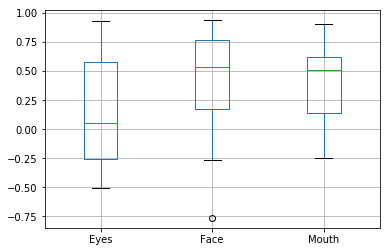

In [9]:
pd.DataFrame({'Face':face_pear_corr_vals, 'Mouth':mouth_pear_corr_vals, 'Eyes':eyes_pear_corr_vals}).boxplot(column=['Eyes', 'Face', 'Mouth'])

In [11]:
for key in vid_only:
    print(key)

ID173_vid6
ID120_vid1
ID174_vid2
ID151_vid2
ID135_vid3
ID161_vid3
ID169_vid4
ID181_vid2
ID147_vid5
ID167_vid2
ID119_vid4
ID120_vid4
ID181_vid4
ID129_vid5
ID137_vid6
ID118_vid3
ID128_vid2
ID147_vid2
ID171_vid1
ID170_vid2
ID153_vid3
ID129_vid2
ID174_vid3
ID121_vid5


In [19]:
# this one can take a while..
openface_dir = os.fsencode('/Users/MichaelSmith/Desktop/processed_openface')

openface_dict = {}

for file in os.listdir(openface_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        vid_id = filename[:10]
        df = pd.read_csv(os.path.join(os.fsdecode(openface_dir), filename))
        openface_dict[vid_id] = df




In [42]:
vid_only['ID120_vid1'].average_df.iloc[0]

50.0

In [25]:
openface_dict['ID120_vid1'].iloc[14::15, :]

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
14,15,0,0.467,0.93,1,0.166905,0.628330,-0.759832,-0.070354,0.586026,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29,30,0,0.968,0.98,1,0.210381,0.582224,-0.785337,-0.077531,0.584421,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
44,45,0,1.468,0.98,1,0.257364,0.557907,-0.788988,-0.137573,0.620007,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
59,60,0,1.969,0.93,1,0.227435,0.587360,-0.776712,-0.188619,0.628530,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
74,75,0,2.470,0.98,1,0.179622,0.657007,-0.732173,-0.157361,0.643351,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
89,90,0,2.970,0.98,1,0.150530,0.575211,-0.804036,-0.155510,0.524791,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
104,105,0,3.471,0.98,1,0.001330,0.268946,-0.963154,-0.169307,0.245399,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
119,120,0,3.971,0.98,1,-0.001244,0.311429,-0.950269,-0.138434,0.276837,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
134,135,0,4.472,0.98,1,-0.001752,0.316355,-0.948639,-0.142080,0.308568,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
149,150,0,4.972,0.98,1,0.259406,0.666406,-0.699008,-0.212626,0.693809,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [47]:
vid_only['ID120_vid1'].average_df.iloc[:-1]

0        50.000000
0.5      50.000000
1.0      50.000000
1.5      50.017136
2.0      50.508943
2.5      50.859163
3.0      51.501358
3.5      52.170615
4.0      52.626182
4.5      54.920873
5.0      60.219403
5.5      63.346100
6.0      67.969286
6.5      70.364547
7.0      70.571402
7.5      70.675391
8.0      70.834020
8.5      71.050988
9.0      71.004261
9.5      71.780270
10.0     73.740566
10.5     75.342682
11.0     76.521257
11.5     79.152542
12.0     80.121079
12.5     79.696788
13.0     79.544152
13.5     79.797172
14.0     79.471861
14.5     79.892125
           ...    
165.5    74.700815
166.0    74.648937
166.5    74.880373
167.0    74.781112
167.5    74.711864
168.0    74.857384
168.5    74.589943
169.0    74.201236
169.5    74.151044
170.0    74.940912
170.5    75.658114
171.0    75.892780
171.5    75.998314
172.0    75.866795
172.5    76.539376
173.0    77.282423
173.5    76.739395
174.0    76.547242
174.5    76.534320
175.0    76.005619
175.5    75.243562
176.0    75.

In [57]:
# check if you need to shorten the vid only category -- might not need to...
openface_part = openface_dict['ID120_vid1'].iloc[14::15, :].reset_index(drop=True)
vid_only_part = vid_only['ID120_vid1'].average_df.iloc[:-1].reset_index(drop=True)

merged = pd.concat([openface_part, vid_only_part], axis=1)

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
X_train, X_test, y_train, y_test = train_test_split(openface_part, vid_only_part)

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
#math.sqrt(mean_squared_error(y_test, pred))

mean_absolute_error(y_test, pred)

6.769398713246525

In [95]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  1   4 698 700 701 702 705 712] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [96]:
X_new.shape

(270, 20)

In [99]:
mask = selector.get_support()
new_features = X_train.columns[mask]
print(new_features)

Index([' y_13', ' y_14', ' y_56', ' y_57', ' y_58', ' y_65', ' y_66', ' Y_13',
       ' Y_56', ' Y_57', ' Y_58', ' Y_65', ' Y_66', ' Y_67', ' AU20_r',
       ' AU45_r', ' AU04_c', ' AU06_c', ' AU07_c', ' AU09_c'],
      dtype='object')
